In [1]:
from datasets import load_dataset
from transformers import AutoModelForMaskedLM, AutoTokenizer
from evaluate import load

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/home/uj-user/Yo/HiT5/HCLT/hclt-venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-09-08 12:59:57,293] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
kullm_dataset = load_dataset('nlpai-lab/kullm-v2')
print(kullm_dataset)
print(kullm_dataset['train']['instruction'][1])

koalpaca_dataset = load_dataset('beomi/KoAlpaca-v1.1a')
print(koalpaca_dataset)
print(koalpaca_dataset['train']['instruction'][1])

DatasetDict({
    train: Dataset({
        features: ['id', 'instruction', 'input', 'output'],
        num_rows: 152630
    })
})
어려운 결정을 내려야 했던 순간을 설명해 주세요.
DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'url'],
        num_rows: 21155
    })
})
스웨터의 유래는 어디에서 시작되었나요?


In [7]:
tokenizer = AutoTokenizer.from_pretrained('GPT2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# filtering under 0 token length
kullm_dataset = kullm_dataset.filter(lambda example: len(example['instruction'])>0+text_range[0], num_proc=24)
koalpaca_dataset = koalpaca_dataset.filter(lambda example: len(example['instruction'])>0+text_range[0], num_proc=24)

# kullm_dataset = kullm_dataset.filter(lambda example: len(example['instruction'])<text_range[1], num_proc=24)
# koalpaca_dataset = koalpaca_dataset.filter(lambda example: len(example['instruction'])<text_range[1], num_proc=24)


# filtering over 1024 token length
def preprocess(examples):
    return tokenizer(examples['instruction'])#, padding=True, return_tensors='pt')
trunc_kullm = kullm_dataset['train'].map(preprocess, batched=True, num_proc=24)
trunc_koalpaca = koalpaca_dataset['train'].map(preprocess, batched=True, num_proc=24)

kullm = trunc_kullm.filter(lambda example: len(example['input_ids'])<=1024, num_proc=24)
koalpaca = trunc_koalpaca.filter(lambda example: len(example['input_ids'])<=1024, num_proc=24)
print(kullm)
print(koalpaca)

Filter (num_proc=24): 100%|██████████| 21155/21155 [00:00<00:00, 74722.00 examples/s] 

Dataset({
    features: ['id', 'instruction', 'input', 'output', 'input_ids', 'attention_mask'],
    num_rows: 144070
})
Dataset({
    features: ['instruction', 'output', 'url', 'input_ids', 'attention_mask'],
    num_rows: 21151
})


/home/uj-user/Yo/HiT5/HCLT/hclt-venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


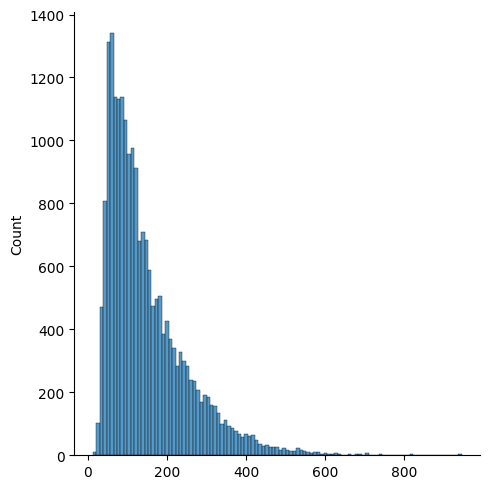

In [8]:
sns.displot([len(t) for t in koalpaca['input_ids']])

In [6]:
# truncate max length, add padding true
def preprocess(examples):
    return tokenizer(examples['instruction'], max_length=1024, truncation=True, padding=True, return_tensors='pt')

trunc_kullm = kullm.map(preprocess, batched=True, num_proc=24)
trunc_koalpaca = koalpaca.map(preprocess, batched=True, num_proc=24)

# extract truncated sentence max_length 1024
def decode_process(examples):
    return {'trunc_instruction': tokenizer.decode(examples['input_ids'], skip_special_tokens=True)}

kullm = trunc_kullm.map(decode_process, num_proc=48)
koalpaca = trunc_koalpaca.map(decode_process, num_proc=48)
print(kullm)
print(koalpaca)

# shuffle dataset (kullm dataset didn't shuffled)
kullm = kullm.shuffle(seed=42)
koalpaca = koalpaca.shuffle(seed=42)

Map (num_proc=24):   0%|          | 0/144070 [00:00<?, ? examples/s]

Map (num_proc=24):   0%|          | 0/21151 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/144070 [00:00<?, ? examples/s]

Map (num_proc=48):   0%|          | 0/21151 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'instruction', 'input', 'output', 'input_ids', 'attention_mask', 'trunc_instruction'],
    num_rows: 144070
})
Dataset({
    features: ['instruction', 'output', 'url', 'input_ids', 'attention_mask', 'trunc_instruction'],
    num_rows: 21151
})


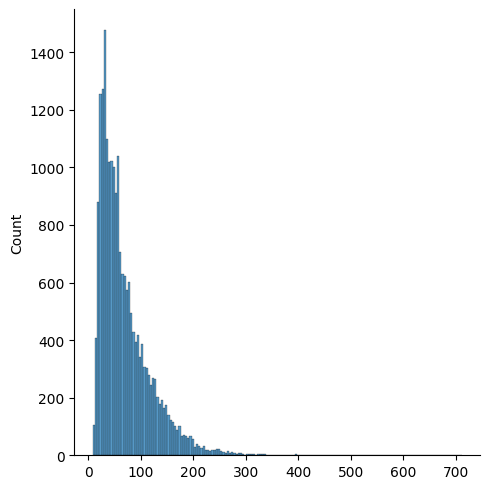

In [7]:
sns.displot([len(t) for t in koalpaca['trunc_instruction']])

In [8]:
koalpaca

Dataset({
    features: ['instruction', 'output', 'url', 'input_ids', 'attention_mask', 'trunc_instruction'],
    num_rows: 21151
})

In [10]:
len(koalpaca['trunc_instruction'])

21151

In [9]:
perplexity = load("perplexity", module_type="metric")
max_sent_num = len(koalpaca['trunc_instruction'])
input_kullm = kullm['trunc_instruction']#[:max_sent_num]
len_kullm = [len(text) for text in input_kullm]

input_koalpaca = koalpaca['trunc_instruction']#[:max_sent_num]
len_koalpaca = [len(text) for text in input_koalpaca]

# kullm_results = perplexity.compute(model_id='gpt2', add_start_token=True, predictions=input_kullm)
koalpaca_results = perplexity.compute(model_id='gpt2', add_start_token=True, predictions=input_koalpaca)

Using pad_token, but it is not set yet.


  0%|          | 0/1322 [00:00<?, ?it/s]

In [129]:
filter_koalpaca_ppl = list(filter(lambda x:x<300, koalpaca_results['perplexities']))
filter_kullm_ppl = list(filter(lambda x:x<300, kullm_results['perplexities']))

(0.0, 30.0)

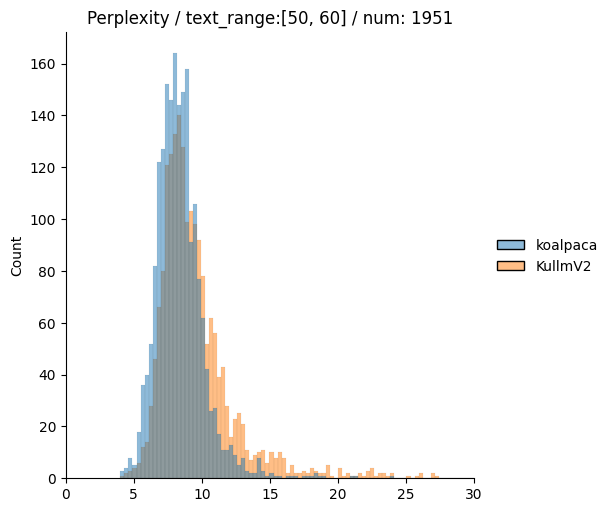

In [130]:
p = sns.displot({'koalpaca':filter_koalpaca_ppl, 'KullmV2':filter_kullm_ppl})
p.set(title=f"Perplexity / text_range:{text_range} / num: {max_sent_num}")
plt.xlim(0,30)

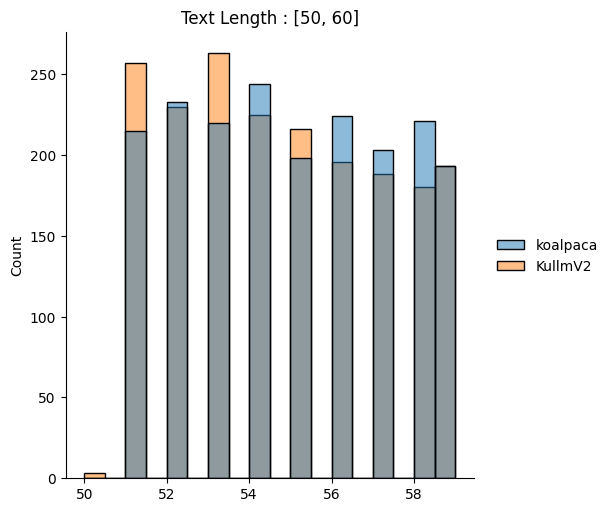

In [131]:
p = sns.displot({'koalpaca':len_koalpaca, 'KullmV2':len_kullm})
p.set(title=f'Text Length : {text_range}')
# plt.xlim(0,3 00)

In [132]:
dict_koalpaca = dict(zip([round(ppl, 2) for ppl in  koalpaca_results['perplexities']], input_koalpaca))
df_koalpaca = pd.DataFrame(sorted(dict_koalpaca.items(), key=lambda x: x[0]), columns=['ppl','text'])

dict_kullm = dict(zip([round(ppl, 2) for ppl in  kullm_results['perplexities']], input_kullm))
df_kullm = pd.DataFrame(sorted(dict_kullm.items(), key=lambda x: x[0]), columns=['ppl','text'])

df_koalpaca.to_json(f'koalpaca_{text_range[0]}_{text_range[1]}.json', orient='records', lines=True, force_ascii=False)
df_kullm.to_json(f'kullm_{text_range[0]}_{text_range[1]}.json', orient='records', lines=True, force_ascii=False)